# Entropy Investigation
The goal of this document is to understand the convergence of the entropy term, as well as how the entropy is calculated and applied to the relative binding energies.

In [1]:
# Loads stuff
import sys
sys.path.insert(0,"/home/lg3u19/OnePy")
import onetep_v0_1 as op
import pathlib
import pandas as pd
pd.set_option('display.precision',3)
import matplotlib.pyplot as plt
import seaborn as sea
import copy

In [2]:
snapshots_5 = ['24801', '32401', '17201', '9601','2001'] 
snapshots_10 = ['24801', '32401', '17201', '13401', '21001', '28601', '9601', '5801','36201','2001'] 
snapshots_25 = [2001, 3521, 5041, 6561, 8081, 9601, 11121, 12641, 14161, 15681, 17201, 18721, 20241, 21761, 23281, 24801, 26321, 27841, 29361, 30881, 32401, 33921, 35441, 36961, 38481]
snapshots_25 = [str(x) for x in snapshots_25]
snapshots_50 = [2001, 2761, 3521, 4281, 5041, 5801, 6561, 7321, 8081, 8841, 9601, 10361, 11121, 11881, 12641, 13401, 14161, 14921, 15681, 16441, 17201, 17961, 18721, 19481, 20241, 21001, 21761, 22521, 23281, 24041, 24801, 25561, 26321, 27081, 27841, 28601, 29361, 30121, 30881, 31641, 32401, 33161, 33921, 34681, 35441, 36201, 36961, 37721, 38481, 39241]
snapshots_50 = [str(x) for x in snapshots_50]

In [3]:
# loading entropy data, same as in analysis.py
entropy_dict ={}
for ligand in ['phenol','methylphenol','catechol','fluoroaniline','hydroxyaniline']:
    entropy_data = pd.read_csv('entropy/'+ligand+'_entropy.txt',delimiter=' ',names=['snapshot','S'])
    entropy_data['snapshot'] = entropy_data['snapshot'].str.split('.').str[1]
    entropy_data = entropy_data.set_index('snapshot') 
    entropy_data['S']=entropy_data['S'].str.strip('a')
    entropy_data = entropy_data.apply(pd.to_numeric)
    entropy_dict[ligand]=entropy_data
entropy_data=False

In [7]:
def entropy_mean(entropy_data,snapshots):
    """ retruns mean over subset of snapshots for entropy, in future, all snaps must be 
    present , else key error raised..."""
    #subset_df = entropy_data.loc[snapshots,:]
    subset_df = entropy_data.reindex(snapshots)
    return subset_df['S'].mean()

In [8]:
def entropy_relative(entropy_dict,snapshots,ligands,reference='phenol'):
    """ retruns series of mean entropies relative to reference """
    # get mean entropies over subset
    temp_dict_mean = {}
    for ligand1 in ligands:
        temp_dict_mean[ligand1] = entropy_mean(entropy_dict[ligand1],snapshots)
    # calc relative to reference entropy
    temp_dict_rel = {}
    for ligand2 in ligands:
        if ligand2!=reference:
            temp_dict_rel[ligand2] = temp_dict_mean[ligand2] - temp_dict_mean[reference]
    return pd.Series(temp_dict_rel)

In [9]:
def entropy_rel_wrapper(entropy_dict,index,paper=True):
    list_of_series = []
    list_of_names = []
    # if passed a list of list of indexes
    if all(isinstance(i, list) for i in index) == True:
        for subset in index:
            list_of_series.append(entropy_relative(entropy_dict,subset,entropy_dict.keys()))
            list_of_names.append(len(subset))
        entropy_paper = pd.Series({'catechol':-0.4,'methylphenol':-1.5,'fluoroaniline':-1.1,
                           'hydroxyaniline':-1.1})
        if paper==True:
            list_of_series.append(entropy_paper)
            list_of_names.append('paper')
        return pd.concat(list_of_series,axis=1,keys=list_of_names,sort=True)
        

In [10]:
df_entropy = entropy_rel_wrapper(entropy_dict,[snapshots_5,snapshots_10,snapshots_25,snapshots_50])
df_entropy

,5,10,25,50,paper
catechol,1.030,1.169,0.058,-0.396,-0.4
fluoroaniline,2.853,1.773,-0.647,-1.155,-1.1
hydroxyaniline,2.282,2.168,0.137,-1.013,-1.1
methylphenol,1.082,0.472,-1.198,-1.553,-1.5


There does appear to be a trend of convergence from 25 to 50 snapshots was compared to 5 and 10. Clearly 5 and 10 are not converged at all. Given the large change between 25 and 50 still present, I assume that the entropy term over 50 snaps is not remotely converged. The values obtained by subtracting values in the table of the 2014 paper are within rounding errors of my 50 snapshot results. Hence, it is likely that A) I have the correct snaps B) I am processing results in the same manner

## Analysis of Get-bash script

- Loops over all complex nab outfiles
- for each complex file do for host and ligand file too
- - grab line of text that begins Total, then grabs a number, which I presume to be the third column, i.e S
- - apply the formula (complex-host-ligand)*0.3, appends letter a  
0.3 factor is an approximate compound conversion factor, T=300k, nad cal/mol to kcal/mol

In [11]:
entropy_dict['phenol'].loc[[str(x) for x in snapshots_5],:]

,S
snapshot,
24801,-17.709
32401,-16.143
17201,-12.536
9601,-16.011
2001,-19.271


## Stude of convergence of Entropy  
The idea is to sample randomly from the 50 entropy snaps to study the convergence of a) the net entropy values, b) the relative entropies w.r.t phenol

In [12]:
entropy_dict['phenol'].mean()

S   -14.219
dtype: float64

In [13]:
# build a function, that takes mean, std, sem or other and return df with that statistic over some subset
def subset_statistic(data,index,statistic,column):
    """ given df, index subset as list and column name, computes statistic"""
    subset_df = data.reindex(index)
    return getattr(subset_df[column],statistic)()

In [14]:
def series_subset_statistic(data,index,statistics,column):
    """ given data frame creates df of statistics of one column
        statistics is list of statistics """
    temp_dict = {}
    for statistic in statistics:
        temp_dict[statistic] = subset_statistic(data,index,statistic,column)
    return pd.Series(temp_dict)
        

In [15]:
def series_subset_statistic_indexes(data,indexes,statistic,column):
    """ given data frame creates df of statistics of one column
        indexes is nested list of indexes """
    temp_dict = {}
    for index in indexes:
        temp_dict[len(index)] = subset_statistic(data,index,statistic,column)
    return pd.Series(temp_dict)
        

In [16]:
def df_subset_statistic(data_dict,index,statistics,column):
    """ given dict of df, applies list of statistics to column in each and returns summary df"""
    temp_dict = {}
    # if list of lists of indexes give:  
    if type(statistics) is list:
        if any(isinstance(i, list) for i in index) == True:
            print ('either list of stats or indexes')
            return False
        else:
            for key in data_dict.keys():
                temp_dict[key] = series_subset_statistic(data_dict[key],index,statistics,column)
            return pd.DataFrame(temp_dict)
    elif all(isinstance(i, list) for i in index) == True:
        if type (statistics) is not list:
            for key in data_dict.keys():
                temp_dict[key] = series_subset_statistic_indexes(data_dict[key],index,statistics,column)
            return pd.DataFrame(temp_dict)
                
    

In [17]:
def df_subset_statistic(data_dict,index,statistics,column):
    """ given dict of df, applies list of statistics to column in each and returns summary df"""
    temp_dict = {}
    # determine if list of statistics given and if nested list of indexes given
    # is list of statistics given:
    if type(statistics) is list:
        # if indexes is a nested list :
        if all(isinstance(i, list) for i in index) == True:
            for key in data_dict.keys():
                temp_dict_inner = {}
                for subset in index:
                    temp_dict_inner[len(subset)]=series_subset_statistic(data_dict[key],subset,statistics,column)
                temp_dict[key]=temp_dict_inner
            return op.df_from_dict_2nested(temp_dict)
        else:
            for key in data_dict.keys():
                temp_dict[key] = series_subset_statistic(data_dict[key],index,statistics,column)
            return pd.DataFrame(temp_dict)
    elif all(isinstance(i, list) for i in index) == True:
        if type (statistics) is not list:
            for key in data_dict.keys():
                temp_dict[key] = series_subset_statistic_indexes(data_dict[key],index,statistics,column)
            return pd.DataFrame(temp_dict)
                
    

In [18]:
summary_entropy = df_subset_statistic(entropy_dict,snapshots_50,['mean','std','sem','var'],column='S')
summary_entropy

,phenol,methylphenol,catechol,fluoroaniline,hydroxyaniline
mean,-14.219,-15.772,-14.615,-15.374,-15.232
std,2.721,3.544,3.595,2.976,2.584
sem,0.385,0.506,0.508,0.421,0.369
var,7.404,12.561,12.927,8.854,6.675


In [19]:
convergence_entropy = df_subset_statistic(entropy_dict,[snapshots_5,snapshots_10,snapshots_25,snapshots_50],
                                          'sem',column='S')
convergence_entropy

,phenol,methylphenol,catechol,fluoroaniline,hydroxyaniline
5,1.120,0.884,0.865,1.766,1.678
10,0.807,0.763,1.477,1.003,0.905
25,0.556,0.785,0.636,0.615,0.547
50,0.385,0.506,0.508,0.421,0.369


In [20]:
list_of_indexes = [snapshots_5,snapshots_10,snapshots_25,snapshots_50]
list_of_stats = ['mean','std','sem','var']
summary_entropy = df_subset_statistic(entropy_dict,list_of_indexes,list_of_stats,column='S')
summary_entropy.transpose()

mean    std    sem     var
catechol       5  -15.304  1.935  0.865   3.744
               10 -14.849  4.671  1.477  21.817
               25 -14.785  3.181  0.636  10.121
               50 -14.615  3.595  0.508  12.927
fluoroaniline  5  -13.481  3.949  1.766  15.597
               10 -14.245  3.173  1.003  10.065
               25 -15.490  3.077  0.615   9.470
               50 -15.374  2.976  0.421   8.854
hydroxyaniline 5  -14.052  3.752  1.678  14.081
               10 -13.850  2.863  0.905   8.195
               25 -14.706  2.679  0.547   7.176
               50 -15.232  2.584  0.369   6.675
methylphenol   5  -15.252  1.976  0.884   3.903
               10 -15.547  2.288  0.763   5.233
               25 -16.041  3.925  0.785  15.404
               50 -15.772  3.544  0.506  12.561
phenol         5  -16.334  2.504  1.120   6.270
               10 -16.018  2.552  0.807   6.513
               25 -14.843  2.782  0.556   7.738
               50 -14.219  2.721  0.385   7.404

In [21]:
# now want to randomly sellect x number of snaps , create table , add all tables and devide by n to get average quantities
import random 
sample_50 = random.sample(snapshots_50,50)

In [22]:
def random_sampling_stats(N,population,sample_sizes,processing_function,arg_dict,index_arg='index'):
    """ given a population of indexes, selects random samples of sizes sample_sizes and
    applies the processing_function, with a list of smaples (sample_list), and arg_dict"""
    count = 0
    df_list = []
    while count < N:
        count +=1
        sample_list = []
        # generate list of samples of appropriate sizes
        for size in sample_sizes:
            sample_list.append(random.sample(population,size))
        # adds the list of sumples as item in arg_dict with correct index_name, defaul name 'index'
        # carefull if processing function takes only on index list, might need to modify to unpack
        # one element list in that case
        arg_dict[index_arg]=sample_list
        # generate df for this iteration and append to list 
        df_list.append(processing_function(**arg_dict))
    return df_list

In [23]:
def average_over_multiple_df(list_of_df):
    local_list = copy.deepcopy(list_of_df)
    for i in range(1,len(local_list)):
        local_list[0]+=local_list[i]
    return local_list[0]/len(local_list)

In [ ]:
arg_dict = {'data_dict':entropy_dict, 'statistics':['mean','std','sem','var'], 'column':'S'}
df_list = random_sampling_stats(100,snapshots_50,list(range(2,51)),df_subset_statistic,arg_dict)
average = average_over_multiple_df(df_list)

In [24]:
arg_dict = {'data_dict':entropy_dict, 'statistics':'sem', 'column':'S'}
df_list_sem = random_sampling_stats(100,snapshots_50,list(range(5,51)),df_subset_statistic,arg_dict)
average_sem = average_over_multiple_df(df_list_sem)

Text(0.5, 0, 'Num of snaps')

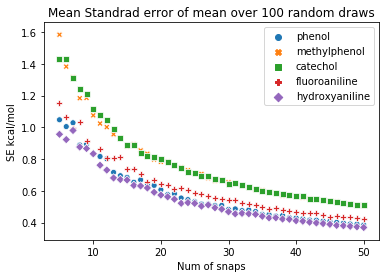

In [25]:
convergence = sea.scatterplot(data=average_sem)
convergence.set_title('Mean Standrad error of mean over 100 random draws')
convergence.set_ylabel('SE kcal/mol')
convergence.set_xlabel('Num of snaps')

# Look at convergence of Entropy correction term to binding energies5

In [26]:
# process list of dfs to study convergence of mean over resamples with x number of snaps
# look at only one ligand for now
def convergence_of_mean(df_list,indexes=['catechol','fluoroaniline'],columns=[5,10,15,25],bin_width=5):
    """ given list of df of same shape, calcs mean over ever increasing subsets of this list of df, 
    for indexes in indexes and columns in columns, with increments of bin_width """
    # create dictionary of correct structure
    temp_dict = {}
    for index in indexes:
        temp_dict[index] = {}
        for column in columns:
            temp_dict[index][column]=[]
    # loop over substes of df_list of increasing size by increment bin_width
    index_list = []
    for i in range(bin_width,int(len(df_list)+bin_width),bin_width):
        index_list.append(i)
        temp_average_df = average_over_multiple_df(df_list[0:i])
        for index in indexes:
            for column in columns:
                temp_dict[index][column].append(temp_average_df.loc[index,column])
    return temp_dict, index_list
    

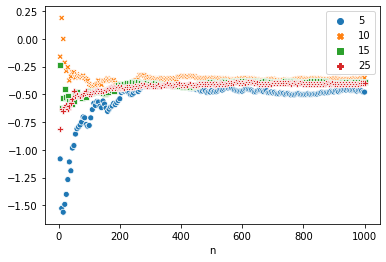

In [27]:
arg_dict = {'entropy_dict':entropy_dict}
correction_term_list = random_sampling_stats(1000,snapshots_50,[5,10,15,25,50],entropy_rel_wrapper,arg_dict,index_arg='index')
correction_term_average = average_over_multiple_df(correction_term_list)
correction_term_average

convergence_of_mean_dict, index_list = convergence_of_mean(correction_term_list)
catechol_mean_conv = pd.DataFrame(convergence_of_mean_dict['catechol'])
catechol_mean_conv['n'] = index_list
catechol_mean_conv = catechol_mean_conv.set_index('n')
sea.scatterplot(data=catechol_mean_conv)

# Draw individual conversion lines for random choices at 1,2,3 ... 50 snaps for one ligand

Text(0, 0.5, 'Relative entropy correction kcal/mol')

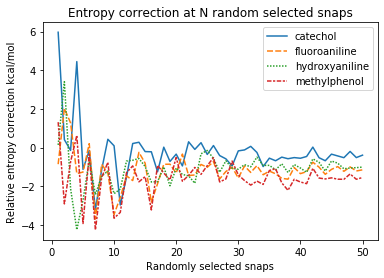

In [28]:
arg_dict = {'entropy_dict':entropy_dict,'paper':False}
correction_term_list = random_sampling_stats(1,snapshots_50,list(range(1,51)),entropy_rel_wrapper,arg_dict,index_arg='index')
correction_term_average = average_over_multiple_df(correction_term_list)
plot_random_sample_convergence = sea.lineplot(data=correction_term_average.transpose())
plot_random_sample_convergence.set_title('Entropy correction at N random selected snaps')
plot_random_sample_convergence.set_xlabel('Randomly selected snaps')
plot_random_sample_convergence.set_ylabel('Relative entropy correction kcal/mol')

Text(0, 0.5, 'Relative entropy correction kcal/mol')

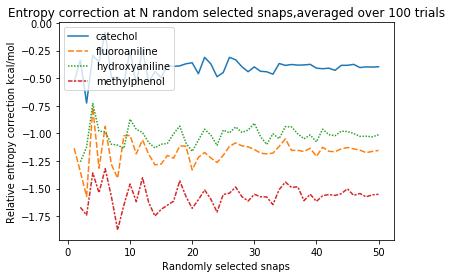

In [29]:
arg_dict = {'entropy_dict':entropy_dict,'paper':False}
correction_term_list = random_sampling_stats(100,snapshots_50,list(range(1,51)),entropy_rel_wrapper,arg_dict,index_arg='index')
correction_term_average = average_over_multiple_df(correction_term_list)
plot_random_sample_convergence = sea.lineplot(data=correction_term_average.transpose())
plot_random_sample_convergence.set_title('Entropy correction at N random selected snaps,averaged over 100 trials')
plot_random_sample_convergence.set_xlabel('Randomly selected snaps')
plot_random_sample_convergence.set_ylabel('Relative entropy correction kcal/mol')
